# Deep Learning Project: Image Super-Resolution

```
Course Instructor: 
+ Nikos Deligiannis
Teaching Assistants:
+ Lusine Abrahamyan
+ Giannis Bekoulis

Student Group:
+ Esteban Velásquez Rendón
+ Andrzej Krzysztof Pietrusiak
+ Amna Jouini

MSc. Applied Computer Science 2021-2022
```

# DATA


Before importing data make sure project has following structure  
[link to data folder](https://vub-my.sharepoint.com/:f:/g/personal/andrzej_krzysztof_pietrusiak_vub_be/Epf4LoQX_D9Euude-yENLmgBRVpu0VFMeMONZA9vmfUJXQ)

<pre>
project folder:  
│  
│── main.ipynb  
│   
└───data    
    ├───DIV2K_train_HR/
    ├───DIV2K_valid_HR/
    ├───DIV2K_train_LR_bicubic/
    └───DIV2K_valid_LR_bicubic/
</pre>

# Imports

In [1]:
import cv2 # computer vision librart
import os  # libray to work with paths and systems
from tqdm.notebook import tqdm # progress bar for jupyter notebooks
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import gc
from skimage.metrics import structural_similarity as ssim

C:\Users\teb4n\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\teb4n\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


# Create data for NN
- patches low resolution (train test)
- patches high resolution (train test)
- original low resolution
- original high resolution


In [9]:
def create_patches(path:str, base_size=(2000, 1000) ,patch_size=(150,150), N_of_pathches=1, resolution_divider=10, train_percent:float= 0.8 ):
    if path[-1] != '/':
        path+= '/'
    i=0

    hr_big=[]
    patch_hr=[]
    file_names=[]

    # READ FILES, GET patches in high resolution
    with tqdm(total=N_of_pathches, desc='reading from disk, generating patches') as pbar:
    
        class enough_patches(Exception):
            pass
        try:
            for file in os.listdir(path) :

                if file.split(".")[-1] != "png": # IF FILE FORMAT NOT CORRECT -> SKIP
                    continue
                i+=1
                #Read image, acomodate its size
                img = cv2.imread(path + file)   
                #img = cv2.resize(img, base_size, interpolation = cv2.INTER_AREA)

                if img.shape[0]< patch_size[0] or img.shape[1] < patch_size[1]: # IMG SMALLER THAN PATCH
                    continue

                file_names.append(file)
                
                hr_big.append(img)

                w,h=int(patch_size[0]/1.01), int(patch_size[1]/1.01)
                for x in range(0, img.shape[0]-h, h ):
                    for y in range(0, img.shape[1]-w, w ):
                        cropped= img[x:x+h, y:y+w]
                        patch_hr.append(cropped)
                        pbar.update(1)
                        if len(patch_hr) > N_of_pathches:
                            raise enough_patches
                
        except enough_patches:
            pass

    
    
    # GET downsampled and upsampled patches from previously read data
    with tqdm(total=len(patch_hr), desc='down/up sampling') as pbar2:
        patch_lr=[]
        for p_hr in patch_hr:
            downsampled = cv2.resize(p_hr, (int(p_hr.shape[1]/resolution_divider), int(p_hr.shape[0]/resolution_divider)), interpolation = cv2.INTER_AREA)
            upsample= cv2.resize(downsampled, (p_hr.shape[0], p_hr.shape[1]), interpolation=cv2.INTER_CUBIC) 
            patch_lr.append(upsample)
            pbar2.update(1)

    # GET downsampled and upsampled bigimages from previously read data
    with tqdm(total=len(hr_big), desc='down/up sampling lr_big') as pbar3:
        lr_big=[]
        for p_hr in hr_big:
            downsampled = cv2.resize(p_hr, (int(p_hr.shape[1]/resolution_divider), int(p_hr.shape[0]/resolution_divider)), interpolation = cv2.INTER_AREA)
            upsample= cv2.resize(downsampled, (p_hr.shape[0], p_hr.shape[1]), interpolation=cv2.INTER_CUBIC) 
            lr_big.append(upsample)
            pbar3.update(1)
    

    #Pathes lists To numpy
    print("converting to numpy...", end=" ")
    patch_hr_np=np.array(patch_hr)
    patch_lr_np=np.array(patch_lr)
    print("\033[92m done \033[0m")

    # Train-Test split
    print("splitting for Train-Test...", end=" ")
    indices = np.random.permutation(patch_hr_np.shape[0])
    split_point=int(patch_hr_np.shape[0]*train_percent)
    training_idx, test_idx = indices[:split_point], indices[split_point:] 
    patch_hr_np_training, patch_hr_np_test = patch_hr_np[training_idx,:], patch_hr_np[test_idx,:]
    patch_lr_np_training, patch_lr_np_test = patch_lr_np[training_idx,:], patch_lr_np[test_idx,:]
    print("\033[92m done \033[0m")

    # Normalization
    print("Normalization...", end=" ")
    patch_hr_np_training_normalized=    patch_hr_np_training    /255.0
    patch_lr_np_training_normalized=    patch_lr_np_training    /255.0
    patch_hr_np_test_normalized=        patch_hr_np_test        /255.0
    patch_lr_np_test_normalized=        patch_lr_np_test        /255.0
    

    for i in range(len(hr_big)):
        hr_big[i]= hr_big[i] / 255.0
        lr_big[i]= lr_big[i] / 255.0
    print("\033[92m done \033[0m")

    # if len(hr_big) == 1:
    #     hr_big=np.expand_dims(hr_big, axis=0)

    # from numpy to tensors
    print("Converting to tensors...", end=" ")
    hr_train=   torch.tensor(   np.transpose(patch_hr_np_training_normalized,       (0, 3, 1, 2) )  ).float()
    lr_train=   torch.tensor(   np.transpose(patch_lr_np_training_normalized,       (0, 3, 1, 2) )  ).float()
    hr_test=    torch.tensor(   np.transpose(patch_hr_np_test_normalized,           (0, 3, 1, 2) )  ).float()
    lr_test=    torch.tensor(   np.transpose(patch_lr_np_test_normalized,           (0, 3, 1, 2) )  ).float()
    
    for i in range(len(hr_big)):
        hr_big[i]= torch.tensor(np.transpose(hr_big[i], (2,0,1)  )    ).float()
        lr_big[i]= torch.tensor(np.transpose(lr_big[i], (2,0,1)  )    ).float()
    print("\033[92m done \033[0m")


    if hr_train.dtype!=torch.float32 or lr_train.dtype!=torch.float32 or hr_test.dtype!=torch.float32 or lr_test.dtype!=torch.float32:
        raise TypeError

    print("\033[92m All done \033[0m")
    return hr_train, lr_train, hr_test, lr_test, hr_big, lr_big, file_names


hr_train, lr_train, hr_test, lr_test,  hr_big, lr_big, file_names= create_patches(path="./data/DIV2K_train_HR", N_of_pathches=2)

reading from disk, generating patches:   0%|          | 0/2 [00:00<?, ?it/s]

down/up sampling:   0%|          | 0/3 [00:00<?, ?it/s]

down/up sampling lr_big:   0%|          | 0/1 [00:00<?, ?it/s]

converting to numpy...  done 
splitting for Train-Test...  done 
Normalization...  done 
Converting to tensors...  done 
 All done 


In [63]:
def plot(img,n=2,path=None):
    if type(img)==np.ndarray:
        if len(img.shape) ==3 :
            if img.shape[-1]==3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
            if img.shape[0]==3:
                img=np.transpose(img, (1,2,0) )
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow( img)
        elif len(img.shape) ==4:
            img=img[0]
            img=np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow( img)   

    elif type(img)==torch.Tensor:
        img=img.detach().numpy()
        if len(img.shape)==4:
            img=img[0]
            img=np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow( img)
        else:
            img= np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img )
    elif type(img)==list:
        if len(img)>1:
            figsize=( 20,n*4)
            fig, axs = plt.subplots(n, 1, figsize=figsize, dpi=80)
            for j,(ax, i) in enumerate(zip(axs,img)):
                i=i.numpy()
                i= np.transpose(i, (1,2,0) )
                i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
                ax.imshow(i )
                if j > n:
                    break
        if len(img)==1:
            img=img[0]
            img=img.detach().numpy()
            img=np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow( img)
    if(path!=None):
        plt.savefig(path,facecolor='white', edgecolor='none', dpi=300)



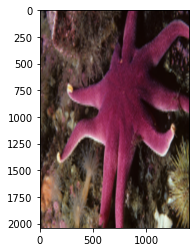

In [354]:
plot(lr_big[0])

# My example


In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()
try:
    del result
    del IN
    del OUT
    del mySRCNN
except NameError: print("OK")

a = torch.cuda.memory_allocated(0)
print("memory_allocated = ",a)
b = torch.cuda.memory_reserved(0)
print("memory_reserved = ",b)

OK
memory_allocated =  0
memory_reserved =  0


In [11]:
torch.cuda.init()
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
devO = torch.device(dev) 
lr_train = lr_train.to(devO)
hr_train = hr_train.to(devO)
lr_test = lr_test.to(devO)
hr_test = hr_test.to(devO)
print("Source: ", devO)

Source:  cuda:0


In [5]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=9, padding= 9//2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [6]:
mySRCNN=SRCNN()
mySRCNN.to(devO)
mySRCNN.train()
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(stupidModel.parameters(), lr=0.01, momentum=0.9)
learning_rate = 0.001
optimizer = torch.optim.Adam(mySRCNN.parameters(), lr=learning_rate)
batch_size=16
running_loss = 0.0
epochs=40
loss_vals=[]
best_epoch=0

mySRCNN.train()
for e in tqdm(range(epochs)):
        for i in range(0, len(lr_train), batch_size):  # loop over the dataset multiple times

                batch_x=  lr_train[i:i+batch_size]
                batch_y=  hr_train[i:i+batch_size]
                
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = mySRCNN(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        loss_vals.append(loss.item())
        #print(e, end=" ")
        #torch.save(stupidModel.state_dict(), "./models/m"+str(e))
print('Finished Training')
mySRCNN.eval()
torch.save(mySRCNN.state_dict(),'./results/model/SRCNN [{}-epochs] [{}-lr] [{}-batchsize]'.format(epochs,learning_rate,batch_size)) #TODO PUT OPTIMIZER


  0%|          | 0/40 [00:00<?, ?it/s]

Finished Training


## BIG TO GPU

In [12]:
lr_big1 = lr_big[0].to(devO)
#hr_big1 = hr_big[0].to(devO)

## Testing the Model (Select BIG or PATCHES)

In [ ]:
result_big= mySRCNN(lr_big1.view(-1, *list(lr_big1.shape) ))  # ONLY BIG
#results= mySRCNN(lr_test[:10]) # ONLY PATCHES

## Detaching and Converting to NUMPY in CPU

In [23]:
# ONLY FOR BIG
big_converted = result_big.cpu().detach().numpy()

In [9]:
# ONLY FOR PATCHES
IN_cpu_np=lr_test.cpu().numpy()
result_cpu_np = results.cpu().detach().numpy()
GT_cpu_np= hr_test.cpu().numpy()

## Plotting Patches Comparison Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


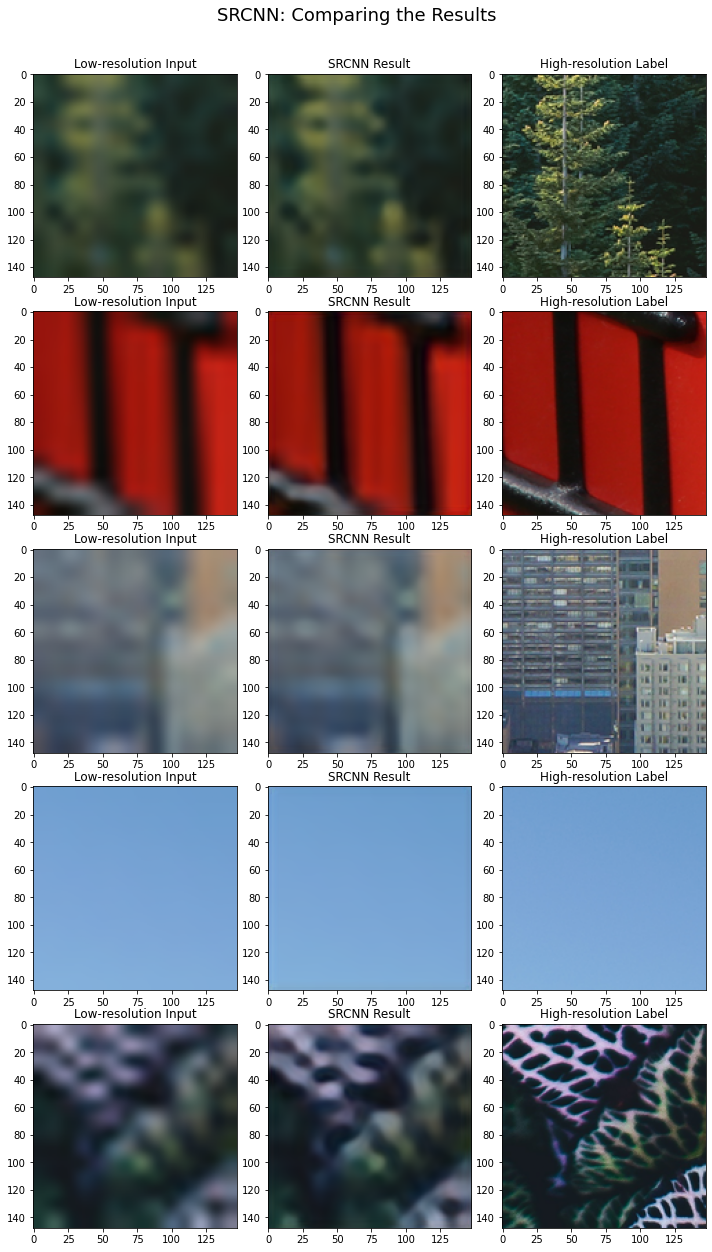

In [11]:
def plot_results(N_of_images_to_plot:int=2, col1:torch.Tensor=None, col2:torch.Tensor=None, col3:torch.Tensor=None, figsize=None, start_from_image=0):
    if figsize == None:
        figsize=(10,N_of_images_to_plot*3.5)
    fig, axs = plt.subplots(N_of_images_to_plot, 3, figsize=figsize)
    fig.suptitle('SRCNN: Comparing the Results', fontsize=18, y=1)
    for i, ax in enumerate(axs):
        i+=start_from_image
        ax[0].imshow( cv2.cvtColor(         np.transpose(col1[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[0].set_title("Low-resolution Input")
        ax[1].imshow( cv2.cvtColor(         np.transpose(col2[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[1].set_title("SRCNN Result")
        ax[2].imshow( cv2.cvtColor(         np.transpose(col3[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[2].set_title("High-resolution Label")
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.15, hspace=0.05)
    plt.savefig('./results/SRCNN [{}-epochs] [{}-lr] [{}-batchsize].png'.format(epochs,learning_rate,batch_size),facecolor='white', edgecolor='none')

plot_results(5,col1=IN_cpu_np, col2=result_cpu_np, col3=GT_cpu_np, start_from_image=5)
torch.save(mySRCNN.state_dict(),'./results/SRCNN [{}-epochs] [{}-lr] [{}-batchsize]'.format(epochs,learning_rate,batch_size))

## Plotting Loss over Iterations

In [68]:
plt.plot(loss_vals, linewidth=4)
plt.title('SRCNN Loss')
plt.xlabel("Epochs")

## TODO SAVE PNG AND PICKLE

NameError: name 'loss_vals' is not defined

# LOADING A SAVED MODEL

In [7]:
mySRCNN = SRCNN()
mySRCNN.load_state_dict(torch.load('results\SRCNN [40-epochs] [0.001-lr] [16-batchsize]'))
mySRCNN = mySRCNN.to(devO)
result_big= mySRCNN(lr_big1.view(-1, *list(lr_big1.shape) ))
result_final = result_big.cpu().detach().numpy()

<All keys matched successfully>

In [69]:
result_rotated = result_final.transpose((0,1,3,2))
res_final_final = np.rot90(result_final,3,[2,3])
finalshitLR= torch.rot90(lr_big[0],3,[1,2])

## Saving BIG IMAGE PLOTS

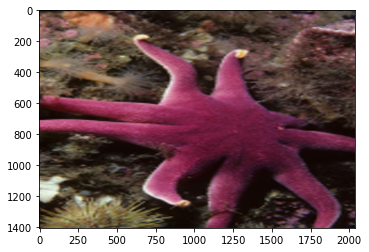

In [64]:
plot(finalshitLR, path = 'BigStar.png')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


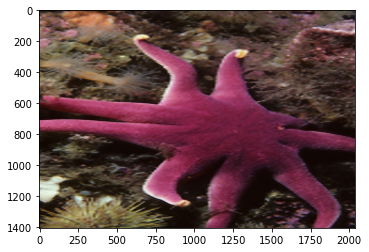

In [65]:
plot(res_final_final, path = 'BigStarRESULT.png')